# **CutMix: Regularization Strategy to Train Strong Classifiers with Localizable Features**

Yun, S., Han, D., Oh, S. J., Chun, S., Choe, J., & Yoo, Y. (2019). Cutmix: Regularization strategy to train strong classifiers with localizable features. In Proceedings of the IEEE/CVF International Conference on Computer Vision (pp. 6023-6032).

Ref.

*https://github.com/jis478/Tensorflow/blob/master/TF2.0/Cutmix/Functions.py*

In [1]:
import tensorflow as tf
import tensorflow_datasets as tfds

import numpy as np

from matplotlib import pyplot as plt

print(f"tf.__version__: {tf.__version__}")
print(f"tfds.__version__: {tfds.__version__}")

tf.__version__: 2.4.1
tfds.__version__: 4.0.1


In [2]:
## The CIFAR10 dataset has a rather small image size and categories, 
## so the effect of CutMix is not visible enough. 
## As an alternative to this, load the caltech_birds2011 dataset.
ds = tfds.load("caltech_birds2011", 
               split = "train", 
               shuffle_files = True, 
               as_supervised = True)

print(f"ds.element_spec: {ds.element_spec}")

Shuffling and writing examples to /root/tensorflow_datasets/caltech_birds2011/0.1.1.incompleteJSTOOD/caltech_birds2011-train.tfrecord


Shuffling and writing examples to /root/tensorflow_datasets/caltech_birds2011/0.1.1.incompleteJSTOOD/caltech_birds2011-test.tfrecord


Dataset caltech_birds2011 downloaded and prepared to /root/tensorflow_datasets/caltech_birds2011/0.1.1. Subsequent calls will reuse this data.
ds.element_spec: (TensorSpec(shape=(None, None, 3), dtype=tf.uint8, name=None), TensorSpec(shape=(), dtype=tf.int64, name=None))


In [120]:
IMAGE_SIZE = [224, 224]

## Or it can be implemented so that PRNG can be initialized with seed.
prng = tf.random.Generator.from_non_deterministic_state()

@tf.function
def sampling(minval = 0, maxval = 1, dtype = tf.float32):
    return prng.uniform([], 
                        minval = minval, 
                        maxval = maxval, 
                        dtype = dtype)
    
## Numpy function.    
def npy_masking_fn(offset_height, offset_width, target_height, target_width):
    ## shape: [*IMAGE_SIZE, 3]
    mask = np.zeros((*IMAGE_SIZE, 3), dtype = np.float32)
    mask[offset_height:target_height, offset_width:target_width, :] = 1.
    return mask


@tf.function
def cut_mix(images, labels, integer_dtype = tf.int32, float_dtype = tf.float32, epsilon = 1e-8):
    assert len(images.shape) == 5, "Only [2, batch_sz, *image_sz] shapes are allowed."

    images_A, images_B = tf.unstack(images, axis = 0)
    labels_A, labels_B = tf.unstack(labels, axis = 0)

    H = images_A.shape[1] 
    W = images_A.shape[2]

    ## If minval = 0, random sampling is performed in the half-open 
    ## interval [0, 1), but the interval we want is (0, 1).
    lam = sampling(minval = epsilon)

    cut_rat = tf.math.sqrt(1. - lam)
    r_w = tf.cast(W * cut_rat, dtype = integer_dtype)
    r_h = tf.cast(H * cut_rat, dtype = integer_dtype)

    ## In the paper, uniform distribution for the interval [0, W(H)] 
    ## was used, but the method was not followed because the content 
    ## was not understood.
    r_x = sampling(maxval = W - r_w, dtype = integer_dtype)
    r_y = sampling(maxval = H - r_h, dtype = integer_dtype)

    ## Cacluate the mask with numpy function.
    mask = tf.numpy_function(npy_masking_fn, 
                             [r_x, r_y, r_w, r_h],
                             tf.float32)
    
    cutmixed_images = mask * images_A + (1. - mask) * images_B
    cutmixed_labels =  lam * labels_A + (1. -  lam) * labels_B

    ## For comparison, images before cutmix are also returned.
    return (images_A, images_B, cutmixed_images), (labels_A, labels_B, cutmixed_labels), lam

    
@tf.function
def resize_and_rescale(image, label):
    image = tf.image.resize(image, IMAGE_SIZE) ## resizing
    image = tf.cast(image, tf.float32) / 255. ## rescaling
    label = tf.cast(label, tf.float32)
    return image, label

In [121]:
AUTO = tf.data.experimental.AUTOTUNE

augmented_ds = ds.cache(
                ).repeat(2
                ).shuffle(20_000
                ).map(resize_and_rescale, num_parallel_calls = AUTO
                ).batch(64
                ).batch(2, drop_remainder = True ## for cutmix
                ).map(cut_mix, num_parallel_calls = AUTO)

In [136]:
for element in augmented_ds.take(1):
    images, labels, lam = element
    print(f"lambda: {lam:.4f}")

lambda: 0.5330


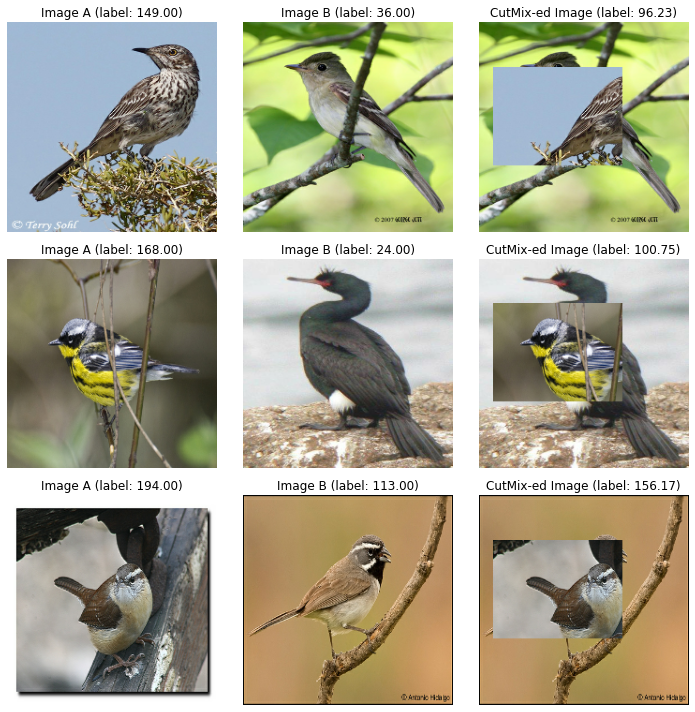

In [138]:
plt.figure(figsize = (10, 10), facecolor = "white")

for i in range(3):
    plt.subplot(3, 3, 3 * i + 1)
    plt.imshow(images[0][i])
    plt.axis("off")
    plt.title(f"Image A (label: {labels[0][i]:.2f})")

    plt.subplot(3, 3, 3 * i + 2)
    plt.imshow(images[1][i])
    plt.axis("off")
    plt.title(f"Image B (label: {labels[1][i]:.2f})")
        
    plt.subplot(3, 3, 3 * i + 3)
    plt.imshow(images[2][i])
    plt.axis("off")
    plt.title(f"CutMix-ed Image (label: {labels[2][i]:.2f})")

plt.tight_layout()
plt.show()